# Task One

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

* Download the monthly natural gas price data.
* Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
* Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
* Your code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

In [1]:
# read the data from the csv file
import pandas as pd
data = pd.read_csv('Nat_Gas.csv')
# display the first few rows of the dataframe
print(data.head())

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


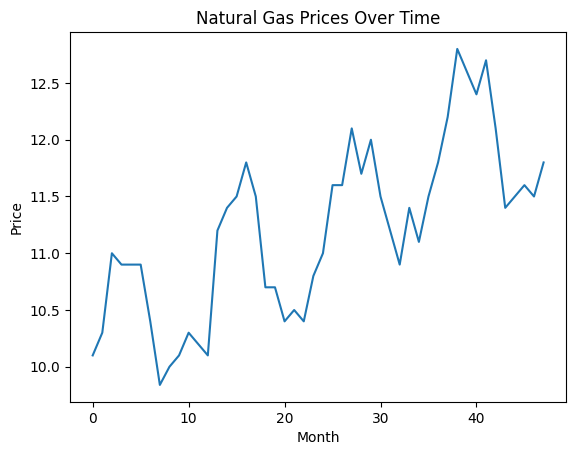

In [2]:
# plot the data
import matplotlib.pyplot as plt
data['Month'] = range(len(data)) # create a simple month index
plt.plot(data['Month'], data['Prices'])
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Natural Gas Prices Over Time')
plt.show()

In [3]:
# Analyze the data to estimate the purchase price of gas at any date in the past and 
# extrapolate it to one year in the future.

# The plotted data displays a seasonal pattern with higher prices in the winter months
# and lower prices in the summer months.
# In addition to that, there is an overall upward trend in prices over the years.
# To estimate the purchase price of gas at any date in the past, we can use a 
# combination of seasonal decomposition and linear regression.
# We can decompose the time series into its seasonal, trend, and residual components.
# Then, we can fit a linear regression model to the trend component to capture the
# overall upward trend in prices.
# Finally, we can use the seasonal component to adjust our predictions for the
# seasonal variations in prices.
# To extrapolate the prices one year into the future, we can extend the trend
# line using the linear regression model and add the seasonal component for the
# corresponding months in the future year.
# Note: The actual implementation of the above analysis would require additional
# code and libraries such as statsmodels for time series decomposition and
# scikit-learn for linear regression.

# Model prediction must be a continution of the historical data without any sudden jumps or drops.

         Date     Prices
36 2024-10-31  12.192789
37 2024-11-30  12.769877
38 2024-12-31  13.149048
39 2025-01-31  13.228845
40 2025-02-28  13.161766
41 2025-03-31  13.243645
42 2025-04-30  12.619480
43 2025-05-31  12.226599
44 2025-06-30  12.137677
45 2025-07-31  12.335838
46 2025-08-31  12.262124
47 2025-09-30  12.512368


/var/folders/36/bbyhz1612x59sr44ryqzp3580000gn/T/ipykernel_14252/2720685635.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Dates'])


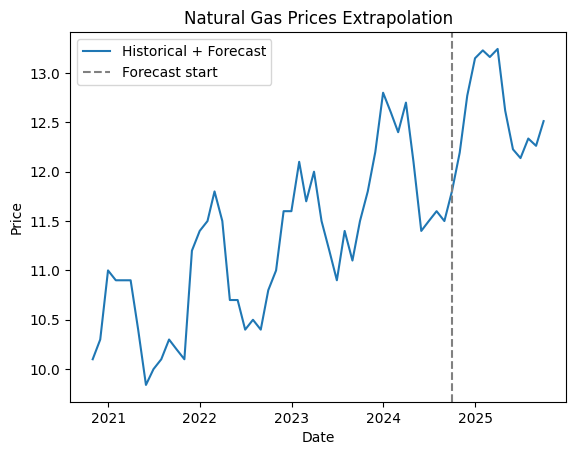

In [4]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# Ensure dates are sorted and numeric
data['Date'] = pd.to_datetime(data['Dates'])
data = data.sort_values('Date').reset_index(drop=True)

# Decompose and keep the edges instead of dropping them
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12, extrapolate_trend='freq')
data['Trend'] = decomposition.trend.interpolate(limit_direction='both')
seasonal = decomposition.seasonal

# Fit the trend component
X = np.arange(len(data)).reshape(-1, 1)
y = data['Trend'].values
model = LinearRegression().fit(X, y)

# Predict future prices (next 12 months)
future_months = np.arange(len(data), len(data) + 12).reshape(-1, 1)
predicted_trend = model.predict(future_months)
predicted_seasonal = seasonal[-12:]
predicted_prices = predicted_trend + predicted_seasonal
future_dates = pd.date_range(data['Date'].iloc[-1] + MonthEnd(), periods=12, freq='ME')
prediction_df = pd.DataFrame({'Date': future_dates, 'Prices': predicted_prices})
print(prediction_df)

# Build a combined series so we can interpolate any date
full_series = pd.concat([
    data[['Date', 'Prices']],
    prediction_df
], ignore_index=True).set_index('Date').sort_index()['Prices']

# Plot historical + forecast
plt.plot(full_series.index, full_series.values, label='Historical + Forecast')
plt.axvline(data['Date'].iloc[-1], color='gray', linestyle='--', label='Forecast start')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices Extrapolation')
plt.legend()
plt.show()


In [5]:
# Construct a function to estimate price at any date
def estimate_price_at(date_str: str) -> float:
    target = pd.to_datetime(date_str)
    filled = full_series.reindex(full_series.index.union([target])).sort_index().interpolate(method='time')
    return float(filled.loc[target])

print('Example lookup 2025-01-15:', estimate_price_at('2025-01-15'))

Example lookup 2025-01-15: 13.187659417344504


# Task Two

The desk now has the price data they need. The final ingredient before they can begin trading with the client is the pricing model. Alex tells you the client wants to start trading as soon as possible. They believe the winter will be colder than expected, so they want to buy gas now to store and sell in winter in order to take advantage of the resulting increase in gas prices. They ask you to write a script that they can use to price the contract. Once the desk are happy, you will work with engineering, risk, and model validation to incorporate this model into production code.

The concept is simple: any trade agreement is as valuable as the price you can sell minus the price at which you are able to buy. Any cost incurred as part of executing this agreement is also deducted from the overall value. So, for example, if I can purchase a million MMBtu of natural gas in summer at $2/MMBtu, store this for four months, and ensure that I can sell the same quantity at $3/MMBtu without incurring any additional costs, the value of this contract would be ($3-$2) *1e6 = $1million. If there are costs involved, such as having to pay the storage facility owner a fixed fee of $100K a month, then the 'value' of the contract, from my perspective, would drop by the overall rental amount to $600K. Another cost could be the injection/withdrawal cost, like having to pay the storage facility owner $10K per 1 million MMBtu for injection/withdrawal, then the price will further go down by $10K to $590K. Additionally, if I am supposed to foot a bill of $50K each time for transporting the gas to and from the facility, the cost of this contract would fall by another $100K. Think of the valuation as a fair estimate at which both the trading desk and the client would be happy to enter into the contract. 

You need to create a prototype pricing model that can go through further validation and testing before being put into production. Eventually, this model may be the basis for fully automated quoting to clients, but for now, the desk will use it with manual oversight to explore options with the client. 

You should write a function that is able to use the data you created previously to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before. Consider all the cash flows involved in the product.

The input parameters that should be taken into account for pricing are:

1. Injection dates. 
2. Withdrawal dates.
3. The prices at which the commodity can be purchased/sold on those dates.
4. The rate at which the gas can be injected/withdrawn.
5. The maximum volume that can be stored.
6. Storage costs.

Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. Test your code by selecting a few sample inputs.

In [6]:
# Write the fuction that takes the above inputs and returns the value of the contract.

def calculate_contract_value(buy_date: str, sell_date: str, quantity_mmbtu: float, storage_cost_per_month: float,
                             injection_withdrawal_cost_per_one_million_mmbtu: float) -> float:
    buy_price = estimate_price_at(buy_date)
    sell_price = estimate_price_at(sell_date)
    
    # Calculate the number of months the gas is stored
    buy_dt = pd.to_datetime(buy_date)
    sell_dt = pd.to_datetime(sell_date)
    storage_months = (sell_dt.year - buy_dt.year) * 12 + (sell_dt.month - buy_dt.month)
    
    # Calculate total costs
    total_storage_cost = storage_cost_per_month * storage_months
    total_injection_withdrawal_cost = injection_withdrawal_cost_per_one_million_mmbtu * (quantity_mmbtu / 10**6)
    
    total_costs = total_storage_cost + total_injection_withdrawal_cost
    
    # Calculate contract value
    contract_value = (sell_price - buy_price) * quantity_mmbtu - total_costs
    
    return contract_value


In [8]:
# We need to generalize the above function for multiple injection and withdrawal dates
# We must also define a max volume beyond which gas cannot be stored at the time of injection.
# Similarly, at the time of withdrawal, we cannot withdraw more gas than what is stored.
# Also the storage cost will only be applicable to those days when there is non -zero gas stored.

def total_contract_value(buy_dates: list, sell_dates: list, quantity_mmbtu: float, storage_cost_per_month: float, 
                         injection_withdrawal_cost_per_one_million_mmbtu: float, max_volume: float) -> float: 
    # First we sort the buy and sell dates together to process them in chronological order
    events = []
    for buy_date in buy_dates:
        events.append((pd.to_datetime(buy_date), 'buy'))
    for sell_date in sell_dates:
        events.append((pd.to_datetime(sell_date), 'sell'))
    events.sort(key=lambda x: x[0])

    # Initialize variables
    total_value = 0.0
    current_volume = 0.0
    last_event_date = None

    for event_date, event_type in events:
        if last_event_date is not None:
            # Calculate storage cost for the period since the last event
            months_stored = (event_date.year - last_event_date.year) * 12 + (event_date.month - last_event_date.month)
            if current_volume > 0:
                total_value -= storage_cost_per_month * months_stored

        if event_type == 'buy':
            # Check if we can buy the specified quantity without exceeding max volume
            if current_volume + quantity_mmbtu <= max_volume:
                buy_price = estimate_price_at(event_date.strftime('%Y-%m-%d'))
                total_value -= buy_price * quantity_mmbtu
                current_volume += quantity_mmbtu
                total_value -= injection_withdrawal_cost_per_one_million_mmbtu * (quantity_mmbtu / 10**6)
            else:
                print(f"Cannot buy on {event_date.strftime('%Y-%m-%d')}: exceeds max volume.")
        elif event_type == 'sell':
            # Check if we have enough volume to sell
            if current_volume >= quantity_mmbtu:
                sell_price = estimate_price_at(event_date.strftime('%Y-%m-%d'))
                total_value += sell_price * quantity_mmbtu
                current_volume -= quantity_mmbtu
                total_value -= injection_withdrawal_cost_per_one_million_mmbtu * (quantity_mmbtu / 10**6)
            else:
                print(f"Cannot sell on {event_date.strftime('%Y-%m-%d')}: insufficient volume.")

        last_event_date = event_date

    return total_value

In [9]:
# Test that the function works as expected
buy_dates = ['2023-08-15', '2023-09-15', '2023-10-15']
sell_dates = ['2023-11-15', '2023-12-15', '2024-01-15']
quantity_mmbtu = 10**6 # 1 million mmbtu
storage_cost_per_month = 10**5 # 100,000 USD per month
injection_withdrawal_cost_per_one_million_mmbtu = 10**4 # 10,000 USD per million mmbtu
total_value = total_contract_value(buy_dates, sell_dates, quantity_mmbtu, storage_cost_per_month, 
                                    injection_withdrawal_cost_per_one_million_mmbtu, max_volume=5*10**6)
print('Total contract value for multiple dates in million USD:', total_value / 10**6)

Total contract value for multiple dates in million USD: 2.433548387096774
